# Ticket categorization using BERT

#### Key points to note to deploy this notebook:
1. BERT (Google model does not deploy on Tensorflow 2.0 and hence a separate library called bert-for-tf2 was required
2. Tensorflow 2.0 does not work on Python 3.8 and neither does bert-for-tf2
3. The model uses the 768 uncased BERT model. Ref: https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip. This file will unzip into a folder <b> uncased_L-12_H-768_A-12 </b> with the following files:
    bert_config.json
    bert_model.ckpt.data-00000-of-00001
    bert_model.ckpt.index
    bert_model.ckpt
    vocab.txt
<u>For this script to run and locate the folder, please ensure that the folder mentioned above is copied into a folder named <b>model</b> in your primary data folder (which opens up when you start jupyter notebook)</u>

In [23]:
!pip install bert-for-tf2

In [24]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [63]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 3

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [26]:
df=pd.read_csv('model_df.csv')
df.columns

Index(['Assignment group', 'Clean Description'], dtype='object')

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train, test = train_test_split(df, test_size=0.3, stratify=df['Assignment group'])

In [29]:
train['Assignment group'].nunique()

36

In [30]:
test['Assignment group'].nunique()

36

In [31]:
train.shape

(5950, 2)

In [32]:
train.head()

,Assignment group,Clean Description
3845,GRP_12,need release skv alicona
4718,GRP_0,account lock
4847,GRP_0,account unlock erp sid unlock todd get success...
8422,GRP_19,driver update team drive graphic card laptop ñ...
548,GRP_0,skype meeting add get disabled outlook


# Intent Recognition with BERT

In [39]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [40]:
class IntentDetectionData:
    DATA_COLUMN = "Clean Description"
    LABEL_COLUMN = "Assignment group"
    
    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes
    
        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])
    
    def _prepare(self, df):
        x, y = [], []
    
        for _, row in tqdm(df.iterrows()):
            text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [41]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [42]:
def create_model(max_seq_len, bert_ckpt_file):
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)
    print(bert_output)
    print("bert shape", bert_output.shape)
    
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.1)(cls_out)
    logits = keras.layers.Dense(units=768, activation="relu")(cls_out)
#     logits = keras.layers.Dropout(0.1)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)
    
    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))
    
    load_stock_weights(bert, bert_ckpt_file)
    return model

## Training

In [43]:
classes = train['Assignment group'].unique().tolist()
classes

['GRP_12',
 'GRP_0',
 'GRP_19',
 'GRP_24',
 'GRP_25',
 'GRP_3',
 'GRP_14',
 'GRP_28',
 'GRP_5',
 'GRP_8',
 'GRP_9',
 'GRP_10',
 'GRP_31',
 'GRP_42',
 'GRP_34',
 'GRP_99',
 'GRP_6',
 'GRP_7',
 'GRP_29',
 'GRP_2',
 'GRP_1',
 'GRP_30',
 'GRP_4',
 'GRP_17',
 'GRP_40',
 'GRP_15',
 'GRP_16',
 'GRP_13',
 'GRP_33',
 'GRP_11',
 'GRP_18',
 'GRP_20',
 'GRP_26',
 'GRP_22',
 'GRP_45',
 'GRP_41']

In [46]:
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

5950it [00:01, 3195.68it/s]
2550it [00:00, 3230.01it/s]


max seq_len 1424


In [47]:
data.train_x.shape

(5950, 128)

In [48]:
data.train_x[0]

array([  101,  2342,  2713, 15315,  2615,  4862, 24366,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [49]:
data.train_y

array([ 0,  1,  1, ..., 15,  4,  1])

In [50]:
data.test_y

array([15,  1, 15, ...,  1,  2, 28])

In [64]:
data.train_y = to_categorical(data.train_y)
data.test_y = to_categorical(data.test_y)

In [51]:
data.max_seq_len

128

In [52]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Tensor("bert/Identity:0", shape=(None, 128, 768), dtype=float32)
bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12\bert_model.ckpt into <bert.model.BertModelLayer object at 0x0000025EF8825EC8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [53]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dense_1 (Dense)              (None, 36)                27684     
Total params: 109,508,388
Trainable params: 109,508,388
Non-trainable params: 0
_______________________________________________

In [67]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-6),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [55]:
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [56]:
import time

In [57]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [58]:
time_callback = TimeHistory()

In [68]:
data.train_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [69]:
data.test_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [70]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.2,
  batch_size=10,
  shuffle=True,
  epochs=10
)

Train on 4760 samples, validate on 1190 samples
Epoch 1/10
4760/4760 [==============================] - 268s 56ms/sample - loss: 3.1622 - accuracy: 0.4681 - val_loss: 3.1636 - val_accuracy: 0.4664
Epoch 2/10
4760/4760 [==============================] - 256s 54ms/sample - loss: 3.1616 - accuracy: 0.4689 - val_loss: 3.1625 - val_accuracy: 0.4681
Epoch 3/10
4760/4760 [==============================] - 257s 54ms/sample - loss: 3.1606 - accuracy: 0.4700 - val_loss: 3.1621 - val_accuracy: 0.4681
Epoch 4/10
4760/4760 [==============================] - 256s 54ms/sample - loss: 3.1599 - accuracy: 0.4706 - val_loss: 3.1621 - val_accuracy: 0.4681
Epoch 5/10
4760/4760 [==============================] - 255s 54ms/sample - loss: 3.1597 - accuracy: 0.4706 - val_loss: 3.1621 - val_accuracy: 0.4681
Epoch 6/10
4760/4760 [==============================] - 255s 53ms/sample - loss: 3.1596 - accuracy: 0.4706 - val_loss: 3.1621 - val_accuracy: 0.4681
Epoch 7/10
4760/4760 [==============================] - 25

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve

In [72]:
def graph(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


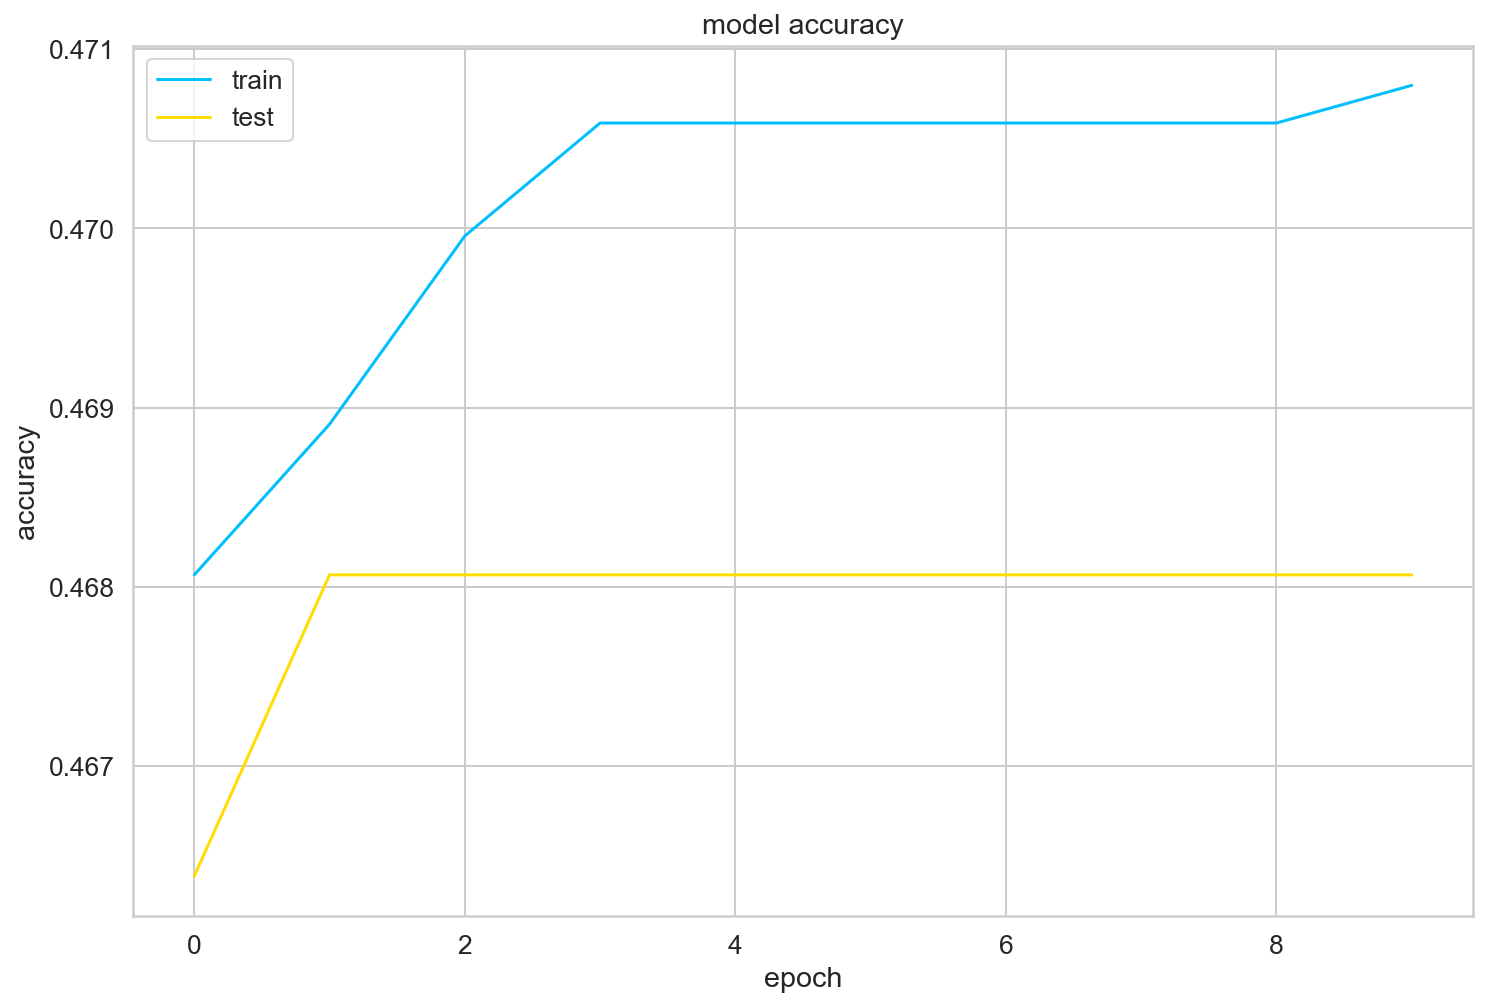

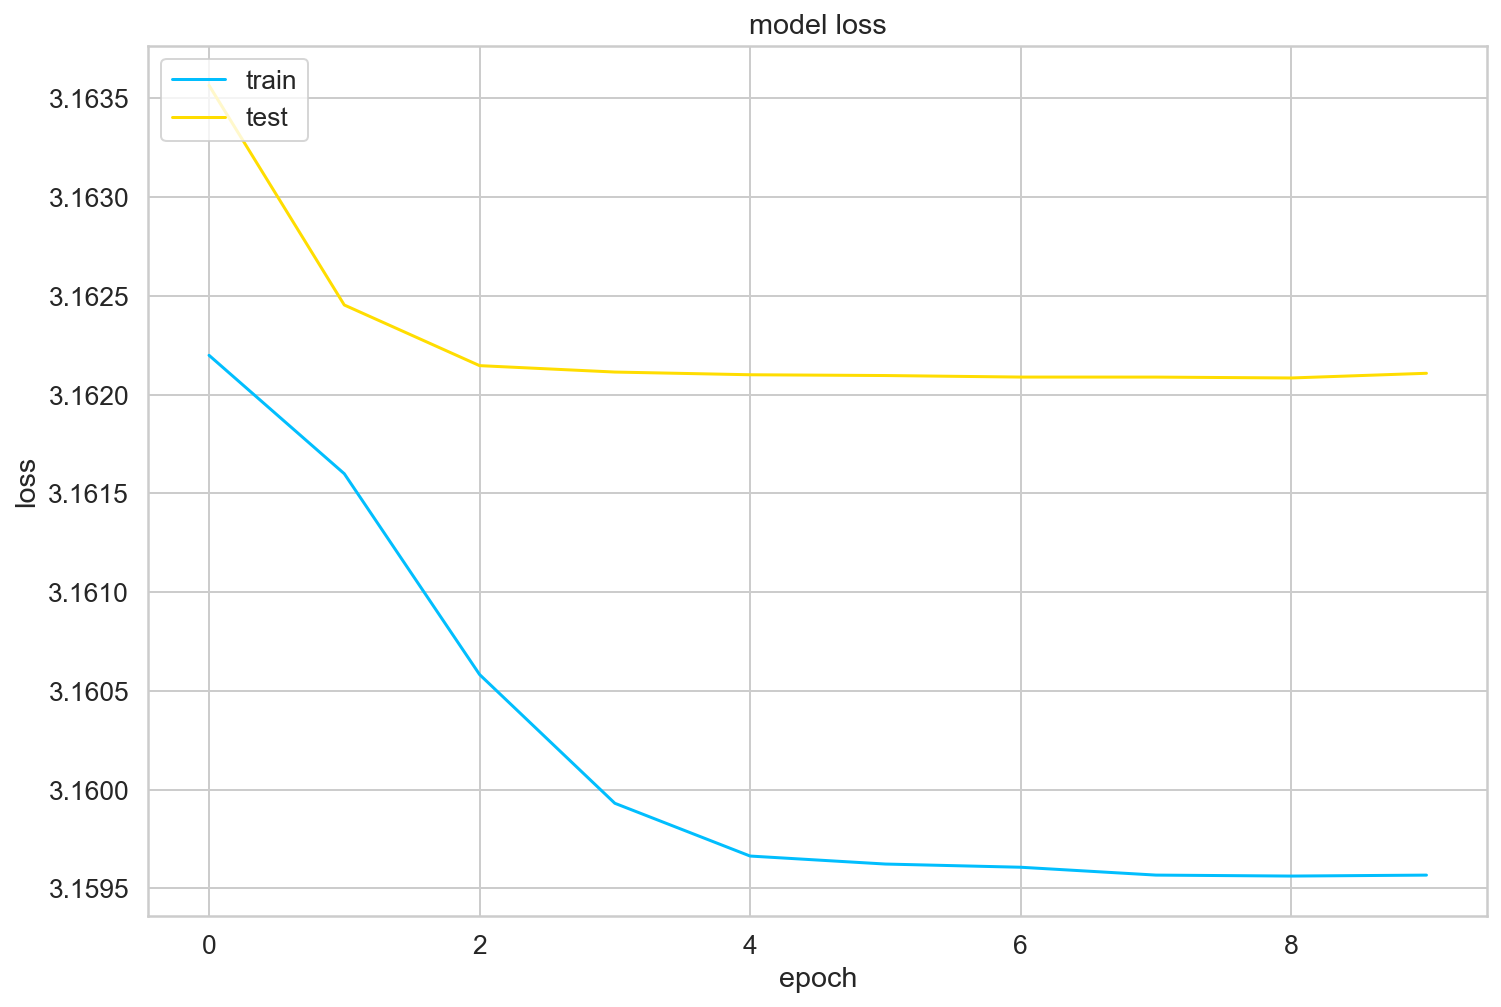

In [73]:
graph(history)

In [80]:
def classification_summary(y_test, y_pred, y_proba):
    print('\033[1mModel accuracy:\033[0m %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('_'*80)
    print('\033[1mConfusion matrix:\033[0m\n %s' % (confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
    print('_'*80)
    print('\033[1mClassification report:\033[0m\n %s' % (classification_report(y_test, y_pred,zero_division='warn')))
    print('_'*80)

In [82]:
y_proba = model.predict(data.test_x)


In [83]:
y_pred = (y_proba > 0.1).astype('int32')

In [84]:
classification_summary(data.test_y, y_pred, y_proba)

Model accuracy: 46.98%
________________________________________________________________________________
Confusion matrix:
 [[   0   77    0 ...    0    0    0]
 [   0 1193    0 ...    0    0    0]
 [   0   64    0 ...    0    0    0]
 ...
 [   0    9    0 ...    0    0    0]
 [   0   10    0 ...    0    0    0]
 [   0   12    0 ...    0    0    0]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.47      1.00      0.64      1193
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        87
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        60
           6       0.00      0.00      0.00        35
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        39
   